# Image Search with Milvus

In [1]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_'
output = './paintings.zip'
gdown.download(url, output)

with zipfile.ZipFile("./paintings.zip", "r") as zip_ref:
    zip_ref.extractall("./paintings")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_
From (redirected): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_&confirm=t&uuid=4141d741-a90f-4c95-b1d7-ccc43266f370
To: E:\sourcecode\py\ml_py_learning\vector-db\paintings.zip
100%|██████████| 2.35G/2.35G [20:34<00:00, 1.90MB/s]


In [2]:
# Milvus Setup Arguments
COLLECTION_NAME = 'image_search'  # Collection name
DIMENSION = 2048  # Embedding vector size in this example
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"

# Inference Arguments
BATCH_SIZE = 128
TOP_K = 3

## Setting up Milvus

In [4]:
from pymilvus import connections

# Connect to the instance
connections.connect(host=MILVUS_HOST, port=MILVUS_PORT)

In [5]:
from pymilvus import utility

# Remove any previous collections with the same name
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

In [6]:
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

# Create collection which includes the id, filepath of the image, and image embedding
fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    # VARCHARS need a maximum length, so for this example they are set to 200 characters
    FieldSchema(name='image_embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]
schema = CollectionSchema(fields=fields)
collection = Collection(name=COLLECTION_NAME, schema=schema)

In [7]:
# Create an AutoIndex index for collection
index_params = {
    'metric_type': 'L2',
    'index_type': "IVF_FLAT",
    'params': {'nlist': 16384}
}
collection.create_index(field_name="image_embedding", index_params=index_params)
collection.load()

## Inserting the data

In [8]:
# 1. Loading the data.
import glob

# Get the filepaths of the images
paths = glob.glob('./paintings/paintings/**/*.jpg', recursive=True)
len(paths)

4978

In [12]:
# 2. Preprocessing the data into batches.
import torch

# Load the embedding model with the last layer removed
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\ping/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ping/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:59<00:00, 1.73MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [13]:
# 3. Embedding the data.
from torchvision import transforms

# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
# 4. Inserting the data into Milvus.
from PIL import Image
from tqdm import tqdm


# Embed function that embeds the batch and inserts it
def embed(data):
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()
        collection.insert([data[1], output.tolist()])


data_batch = [[], []]

# Read the images into batches for embedding and insertion
for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[], []]

# Embed and insert the remainder
if len(data_batch[0]) != 0:
    embed(data_batch)

# Call a flush to index any unsealed segments.
collection.flush()

100%|██████████| 4978/4978 [05:10<00:00, 16.02it/s]


## Performing the search

In [15]:
import glob

# Get the filepaths of the search images
search_paths = glob.glob('./paintings/test_paintings/**/*.jpg', recursive=True)
len(search_paths)

2

In [16]:
import time
from matplotlib import pyplot as plt


# Embed the search images
def embed(data):
    with torch.no_grad():
        ret = model(torch.stack(data))
        # If more than one image, use squeeze
        if len(ret) > 1:
            return ret.squeeze().tolist()
        # Squeeze would remove batch for single image, so using flatten
        else:
            return torch.flatten(ret, start_dim=1).tolist()


data_batch = [[], []]

for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

embeds = embed(data_batch[0])
start = time.time()
res = collection.search(embeds, anns_field='image_embedding', param={'nprobe': 128}, limit=TOP_K,
                        output_fields=['filepath'])
finish = time.time()

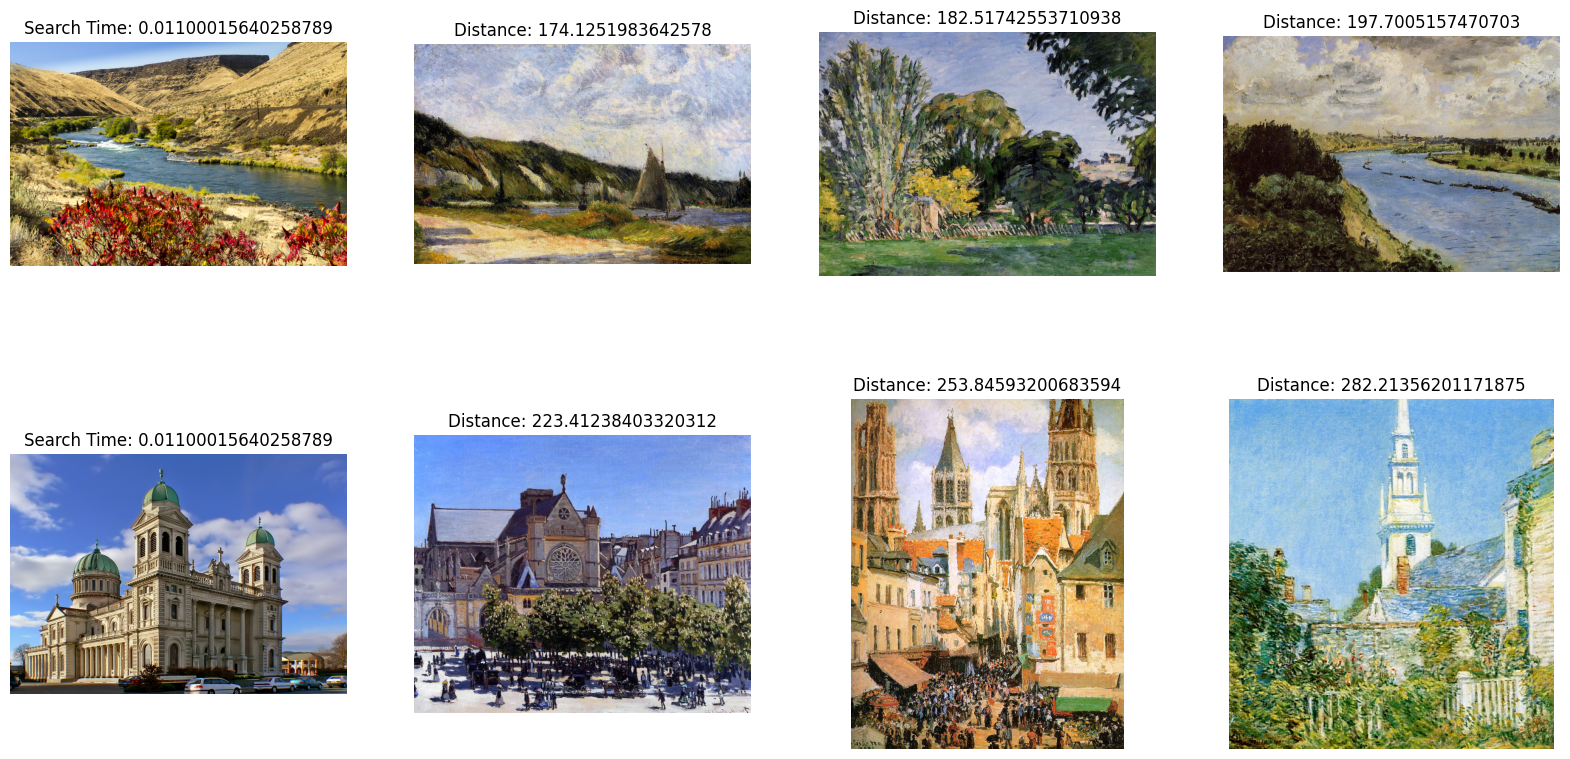

In [17]:
# Show the image results
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

for hits_i, hits in enumerate(res):
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit.entity.get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('Distance: ' + str(hit.distance))

# Save the search result in a separate image file alongside your script.
plt.savefig('search_result.png')